In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.layers import Input, Dense, Lambda, InputLayer, concatenate
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import to_categorical

# Task 1

In [2]:
# load the data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# scale the data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [3]:
# matrix into vector
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [4]:
original_dim = x_train.shape[1]

## a)

From the lecture we know that ELBO equals

$$ELBO = \mathbb{E}_q \log p(x|z) - KL(q(z|x)||p(z)).$$

Assume that we already know the parameters of the encoder 

$$\mathbb{E}_q \log p(x|z) = \mathbb{E}_{\varepsilon} \log p(x|z_{\phi}(\varepsilon, x))$$

Below: 

 - `x` - observed vector of pixels (0 and 1)
 - `x_decoded` - $p(1|z_{\phi}(\varepsilon, x)) = p(1|\mu_{\phi}(x) + \Sigma_{\phi}(x)^{1/2}\varepsilon)$, where $\varepsilon$ was generated according to $\mathcal{N}(0, 1)$ - the aposteriori probability of the pixel being $1$ after reparametrization trick
 - $\Sigma_{\phi}(x) = \textrm{diag}(\sigma_{\phi, 1}^2(x), \sigma_{\phi, 2}^2, \ldots, \sigma_{\phi, K}^2)$
 - `z_mean` - $\mu_{\phi}(x) = (\mu_{\phi, 1}(x), \mu_{\phi, 2}(x), \ldots, \mu_{\phi, K}(x))$
 - `z_log_var` - $(\log\sigma_{\phi, 1}^2(x), \log\sigma_{\phi, 2}^2(x), \ldots, \log\sigma_{\phi, K}^2(x))$

 - $q(z|x) = \mathcal{N}(\mu_{\phi}(x), \Sigma_{\phi}(x))$

Input: `x, x_decoded, z_mean, z_log_var`

Output: ELBO

In [5]:
@tf.function
def elbo_vae(x, x_decoded, z_mean, z_log_var):

    loss_term = tf.reduce_sum(x * tf.math.log(x_decoded + 1e-19) + (1 - x) * tf.math.log(1 - x_decoded + 1e-19), 1)

    KL_term =  0.5 * tf.reduce_sum(-z_log_var + tf.exp(z_log_var) + tf.square(z_mean) - 1, 1)

    return tf.reduce_mean(loss_term - KL_term)

## b)

Next we need to get a sample from $q(z|x)$. We will use a reparametrization trick.

Input: `z_mean, z_log_var`

Output: $\mathcal{N}(\mu_{\phi}(x), \Sigma_{\phi}(x))$

In [6]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## c)

A part of the model that takes input and returns a vector:

$$ (\mu_{\phi, 1}(x), \mu_{\phi, 2}(x), \ldots, \mu_{\phi, K}(x), \log\sigma_{\phi, 1}^2(x), \log\sigma_{\phi, 2}^2(x), \ldots, \log\sigma_{\phi, K}^2(x)) $$

Due to technical reason we will return the above vector and sampled values of $z$ as the output of the encoder (and not as a separate layer).

In [7]:
latent_dim = 10

encoder_inputs = keras.Input(shape=(original_dim,))
x = Dense(256, activation='relu')(encoder_inputs)
x = Dense(256, activation='tanh')(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)               ┃ Output Shape            ┃        Param # ┃ Connected to            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)   │ (None, 784)             │              0 │ -                       │
├────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ dense (Dense)              │ (None, 256)             │        200,960 │ input_layer[0][0]       │
├────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ dense_1 (Dense)            │ (None, 256)             │         65,792 │ dense[0][0]             │
├────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ z_mean (Dense)             │ (None, 10)              │          2,570 │ dense_1[0][0]           │
├────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ z_log_var (Dense)          │ (None, 10)              │          2,570 │ dense_1[0][0]           │
├────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ sampling (Sampling)        │ (None, 10)              │              0 │ z_mean[0][0],           │
│                            │                         │                │ z_log_var[0][0]         │
└────────────────────────────┴─────────────────────────┴────────────────┴─────────────────────────┘

 Total params: 271,892 (1.04 MB)

 Trainable params: 271,892 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# number of parameters:
(784 + 1)*256, (256 + 1)*256, (256 + 1)*latent_dim

(200960, 65792, 2570)

## d)

In [9]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = Dense(256, activation='relu')(latent_inputs)
x = Dense(256, activation='tanh')(x)
decoder_outputs = Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │           2,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 784)                 │         201,488 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 270,096 (1.03 MB)

 Trainable params: 270,096 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

## e)

In [10]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            total_loss = -elbo_vae(data, reconstruction, z_mean, z_log_var)           

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)

        return {"loss": self.total_loss_tracker.result()}        

In [11]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=10, batch_size=128)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 224.0440
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 138.2114
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 125.3866
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 120.0518
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 116.3928
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 113.8919
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 112.0380
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 110.8421
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 109.7786
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 108.6637


## f)

In [12]:
# representation in the latent space of observations from test ds
z_test_pred = encoder.predict(x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [13]:
# in a list z_test_pred indeces mean: 0-vector of means, 1-vector of variances, 2-values in the latent space
# this is a prediction
test_pred = decoder.predict(z_test_pred[2])
# decoder predictions - we take a vector from the latent space and transform it to be again a picture

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

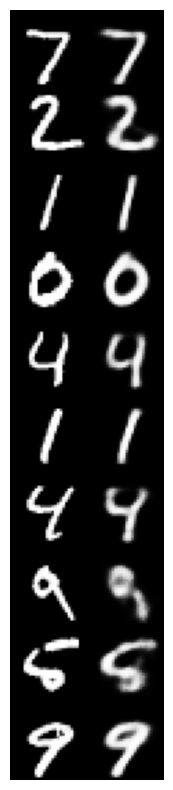

In [15]:
n = 10  # figure with 10 x 2 digits
digit_size = (np.sqrt(original_dim)).astype('int')
fig = plt.figure(figsize=(10, 10))
figure = np.zeros((digit_size * n, digit_size * 2))
decoded = test_pred

for i in range(10):
    figure[i * digit_size: (i + 1) * digit_size, :digit_size] = x_test[i, :].reshape(digit_size, digit_size)
    figure[i * digit_size: (i + 1) * digit_size, digit_size:] = decoded[i, :].reshape(digit_size, digit_size)
    
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()

## g)

In [16]:
# use z_test_pred

In [17]:
from sklearn.manifold import TSNE

In [18]:
tsne = TSNE(n_components=2)

In [19]:
z_test_pred_tsne = tsne.fit_transform(z_test_pred[2])

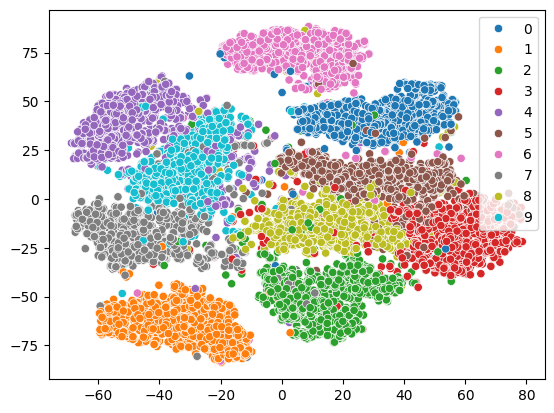

In [20]:
N=10000
sns.scatterplot(x=z_test_pred_tsne[:N,0], y=z_test_pred_tsne[:N,1], hue=y_test[:N], palette=sns.color_palette("tab10"))
plt.show()

## h)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


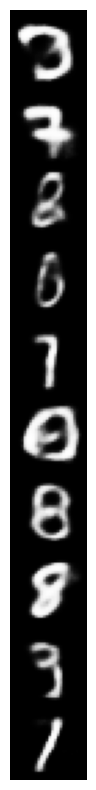

In [35]:
new_z = tf.random.normal((10, 10))
new_z_pred = vae.decoder.predict(new_z)

fig = plt.figure(figsize=(10, 10))
figure = np.zeros((digit_size * n, digit_size))
for i in range(10):
    figure[i * digit_size: (i + 1) * digit_size, :digit_size] = new_z_pred[i, :].reshape(digit_size, digit_size)
    
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()

# Task 2

In [21]:
xy_train = np.concatenate((x_train, y_train.reshape((-1, 1))), axis=1)
xy_test = np.concatenate((x_test, y_test.reshape((-1, 1))), axis=1)

In [22]:
original_dim_cond = xy_train.shape[1]

In [23]:
encoder_inputs_cond = keras.Input(shape=(original_dim_cond,))
x_cond = Dense(256, activation='relu')(encoder_inputs_cond)
x_cond = Dense(256, activation='tanh')(x_cond)
z_mean_cond = layers.Dense(latent_dim, name="z_mean")(x_cond)
z_log_var_cond = layers.Dense(latent_dim, name="z_log_var")(x_cond)
z_cond = Sampling()([z_mean_cond, z_log_var_cond])
encoder_cond = keras.Model(encoder_inputs_cond, [z_mean_cond, z_log_var_cond, z_cond], name="encoder_cond")
encoder_cond.summary()

Model: "encoder_cond"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)               ┃ Output Shape            ┃        Param # ┃ Connected to            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer) │ (None, 785)             │              0 │ -                       │
├────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ dense_5 (Dense)            │ (None, 256)             │        201,216 │ input_layer_2[0][0]     │
├────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ dense_6 (Dense)            │ (None, 256)             │         65,792 │ dense_5[0][0]           │
├────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ z_mean (Dense)             │ (None, 10)              │          2,570 │ dense_6[0][0]           │
├────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ z_log_var (Dense)          │ (None, 10)              │          2,570 │ dense_6[0][0]           │
├────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ sampling_1 (Sampling)      │ (None, 10)              │              0 │ z_mean[0][0],           │
│                            │                         │                │ z_log_var[0][0]         │
└────────────────────────────┴─────────────────────────┴────────────────┴─────────────────────────┘

 Total params: 272,148 (1.04 MB)

 Trainable params: 272,148 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
latent_inputs_cond = keras.Input(shape=(latent_dim+1,))
x_cond = Dense(256, activation='relu')(latent_inputs_cond)
x_cond = Dense(256, activation='tanh')(x_cond)
decoder_outputs_cond = Dense(original_dim, activation='sigmoid')(x_cond)
decoder_cond = keras.Model(latent_inputs_cond, decoder_outputs_cond, name="decoder_cond")
decoder_cond.summary()

Model: "decoder_cond"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 11)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │           3,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 784)                 │         201,488 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 270,352 (1.03 MB)

 Trainable params: 270,352 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
class cVAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

    def train_step(self, data):
        y = tf.cast(data[:, -1], float)[:, None]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            zy = tf.concat([z, y], 1)
            reconstruction = self.decoder(zy)

            total_loss = -elbo_vae(data[:, :-1], reconstruction, z_mean, z_log_var)           

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)

        return {"loss": self.total_loss_tracker.result()}        

In [26]:
cvae = cVAE(encoder_cond, decoder_cond)
cvae.compile(optimizer=keras.optimizers.Adam())
cvae.fit(xy_train, epochs=10, batch_size=128)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 220.3047
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 141.5244
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 129.2311
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 123.0282
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 119.2095
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 115.4004
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 113.2799
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 111.4095
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 110.1849
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 109.2154


In [27]:
# representation in the latent space of observations from test ds
z_test_pred_cond = cvae.encoder.predict(xy_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [28]:
zy_test_pred_cond = tf.concat([z_test_pred_cond[2], y_test[:, None]], 1)

In [29]:
# in a list z_test_pred indeces mean: 0-vector of means, 1-vector of variances, 2-values in the latent space
# this is a prediction
test_pred_cond = cvae.decoder.predict(zy_test_pred_cond)
# decoder predictions - we take a vector from the latent space and transform it to be again a picture

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


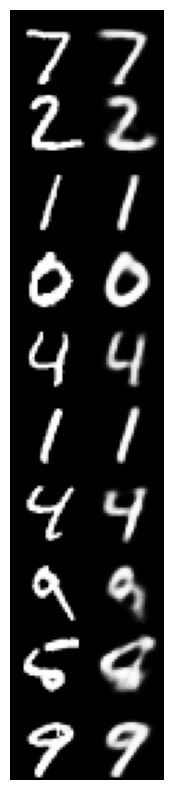

In [30]:
n = 10  # figure with 10 x 2 digits
fig = plt.figure(figsize=(10, 10))
figure = np.zeros((digit_size * n, digit_size * 2))
decoded_cond = test_pred_cond

for i in range(10):
    figure[i * digit_size: (i + 1) * digit_size, :digit_size] = xy_test[i, :original_dim].reshape(digit_size, digit_size)
    figure[i * digit_size: (i + 1) * digit_size, digit_size:] = decoded_cond[i, :original_dim].reshape(digit_size, digit_size)
    
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()

In [31]:
zy_test_pred_tsne = tsne.fit_transform(zy_test_pred_cond)

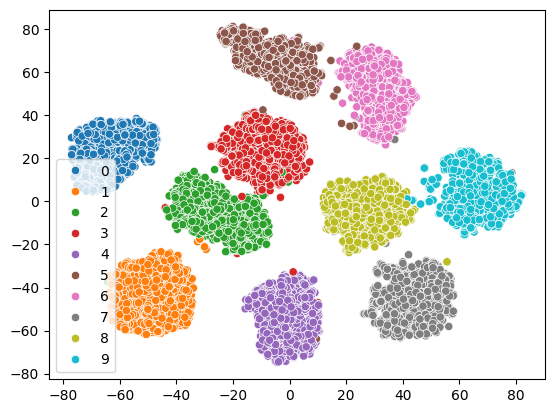

In [32]:
N=10000
sns.scatterplot(x=zy_test_pred_tsne[:N,0], y=zy_test_pred_tsne[:N,1], hue=y_test[:N], palette=sns.color_palette("tab10"))
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


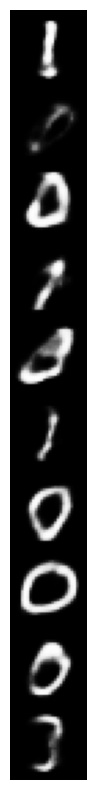

In [37]:
new_z_cond = tf.random.normal((10, 10))
new_z_class = tf.zeros((10, 1))
new_z_full = tf.concat([new_z_cond, new_z_class], 1)
new_z_pred_cond = cvae.decoder.predict(new_z_full)

fig = plt.figure(figsize=(10, 10))
figure = np.zeros((digit_size * n, digit_size))
for i in range(10):
    figure[i * digit_size: (i + 1) * digit_size, :digit_size] = new_z_pred_cond[i, :].reshape(digit_size, digit_size)
    
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()